In [3]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32

In [4]:
def APPM_RT256():
    RT = []
    for i in range(256):
        row = []
        count = (i*60)%256
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 256:
                count -= 256
        RT.append(row)
    RT = np.array(RT)
    return RT

In [5]:
def APPM_RT64():
    RT = []
    for i in range(256):
        row = []
        count = (i*14)%64
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 64:
                count -= 64
        RT.append(row)
    RT = np.array(RT)
    return RT

In [6]:
class Queue():
    def __init__(self):
        self.q = []
        self.r = -1
    def reset(self):
        self.q = []
        self.r = -1    
    def enqueue(self,r,c):
        self.q.append((r,c))
    def dequeue(self):
        self.r += 1
        if self.r >= len(self.q):
            return False
        return self.q[self.r]

In [7]:
def BFS(RT,r,c,g,tol=None,flag=None):
    Q = Queue()
    Q.enqueue(r,c)
    F = np.full((RT.shape[0],RT.shape[1]),False,dtype=bool)
    F[r,c] = True
    while True:
        k = Q.dequeue()
        if k == False:
            break
        if RT[k[0],k[1]] == g:
            if((k[0] > tol[0] and k[0] < tol[2] and k[1] > tol[1] and k[1] < tol[3]) or (flag)):
                return k
            else:
                flag = True

        if k[0] != 0 and not F[k[0]-1,k[1]]:
            Q.enqueue(k[0]-1,k[1])
            F[k[0]-1,k[1]] = True
        if k[0] != RT.shape[0]-1 and not F[k[0]+1,k[1]]:
            Q.enqueue(k[0]+1,k[1]) 
            F[k[0]+1,k[1]] = True
        if k[1] != 0 and not F[k[0],k[1]-1]:
            Q.enqueue(k[0],k[1]-1)
            F[k[0],k[1]-1] = True
        if k[1] != RT.shape[1]-1 and not F[k[0],k[1]+1]:
            Q.enqueue(k[0],k[1]+1)  
            F[k[0],k[1]+1] = True     

In [8]:
def hashB(npArray,bits):
    return np.mod(xxh32(npArray).intdigest(), 2**bits)

In [9]:
def fold(arr,bit):
    k = B2D.Dec2Bin(arr)
    l = len(k)
    while(l > bit):
        l >>= 1
        a = k[:l]
        b = k[l:]
        k = []
        for i in range(l):
            k.append(a[i]^b[i])
    return B2D.Bin2Dec(k)

In [10]:
def rb_tol(Gray,Green):
    base = round(Gray)
    low_tol = Gray - (base - 0.5) + (255 - Green) * 0.587
    up_tol = (base + 0.5) - Gray + (Green) *0.587
    red_low_tol = int(low_tol/0.299)
    blue_low_tol = int(low_tol/0.114)
    red_up_tol = int(up_tol/0.299)
    blue_up_tol = int(up_tol/0.114)


    # print(low_tol,base,Green)

    return np.array([red_low_tol,blue_low_tol,red_up_tol,blue_up_tol])


In [14]:

def AVGI(Graph):
    path = 'image/'+Graph
    I=io.imread(path +r'.tiff')
    Stego = I.copy()
    RT = APPM_RT64()

    p = 0
    MSE = 0
    F = 0

    print(Stego.shape[0],Stego.shape[1],Stego.shape[2])

    for i in range(Stego.shape[0]):
        for j in range(Stego.shape[1]):
            ac = hashB(np.array([Stego[i,j,0]//2**4,Stego[i,j,2]//2**2]),6)
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114

            tol = rb_tol(Gray,Stego[i,j,1])
            tol[0] = Stego[i,j,0] - tol[0]
            tol[1] = Stego[i,j,2] - tol[1]
            tol[2] += Stego[i,j,0]
            tol[3] += Stego[i,j,2]

            k = BFS(RT,Stego[i,j,0],Stego[i,j,2],ac,tol,False)
            # print(f"i: {i} j: {j} k:{k}")
            Stego[i,j,0] = k[0]
            Stego[i,j,2] = k[1]
            g_bar = int(round((Gray - 0.299*k[0] - 0.114*k[1])/0.587))
            if(g_bar < 0 or g_bar > 255):
                p +=1
                Stego[i,j,0] = I[i,j,0]
                num = fold(ac,2)
                Stego[i,j,2] >>= 2
                Stego[i,j,2] <<= 2
                Stego[i,j,2] += num
                # g_bar = int(round((Gray - 0.299*Stego[i,j,0] - 0.114*Stego[i,j,2])/0.587))
                # F.append(g_bar)
                # Stego[i,j,1] = np.clip(g_bar,0,255)
            else:
                Stego[i,j,1] = g_bar

            delta = int(Stego[i,j,0]) - int(I[i,j,0])
            MSE += delta ** 2
            delta = int(Stego[i,j,2]) - int(I[i,j,2])
            MSE += delta ** 2
            delta = int(Stego[i,j,1]) - int(I[i,j,1])
            MSE += delta ** 2        

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p}")

    with open("processing_data/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processing_image/'+Graph+'.png',Stego)




    # ANS = []
    # for i in range(Stego.shape[0]):
    #     for j in range(0,Stego.shape[1],2):
    #         ANS.append(RT[Stego[i,j],Stego[i,j+1]])

    # if np.all(ANS == msg):
    #     print(ANS[100],msg[100])
    # else:
    #     print("F")

512 512 3
PSNR:40.26363665883463 , F:14411


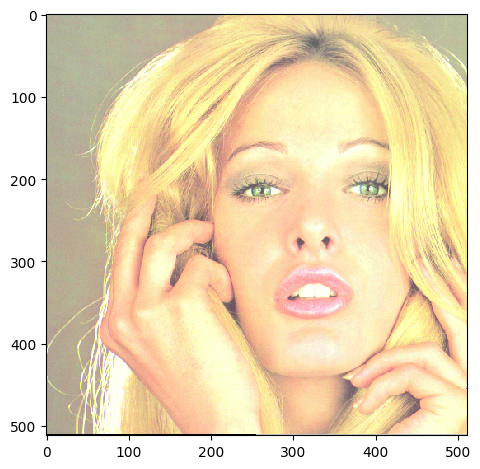

In [15]:
AVGI('Tiffany')